plt b [(0.4, 0.6), (0.4, 0.6)]


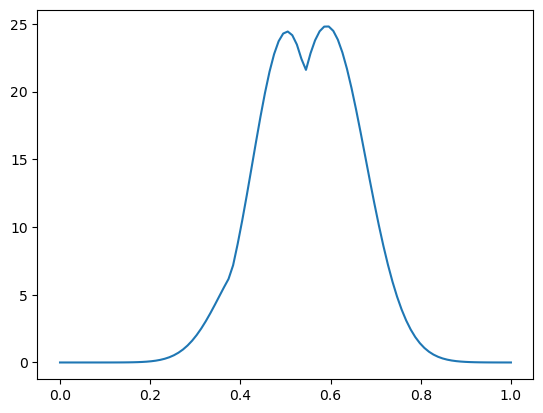

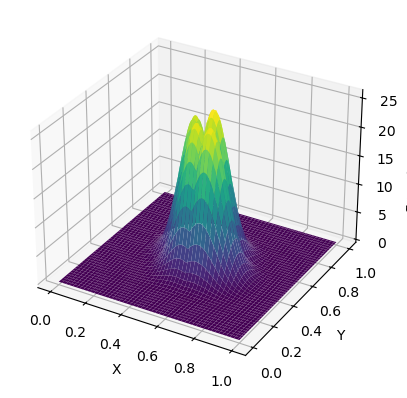

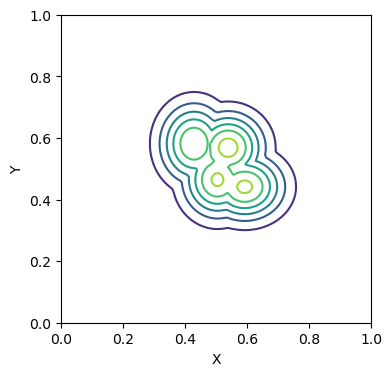

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


from test_functions.max_of_many_gaussians import MaxOfManyGaussians
seed = 10
# mmg = MaxOfManyGaussians(2, 5, [(0,1), (0,1)], std_bounds=(0.1,0.1), seed=seed)
mmg = MaxOfManyGaussians(2, 5, [(0.4,0.6), (0.4,0.6)], std_bounds=(0.005,0.008), seed=seed)

mmg.plot_2d_gaussians()

In [7]:
%matplotlib inline
import numpy as np

import sparseSpACE
from sparseSpACE.Function import *
from sparseSpACE.spatiallyAdaptiveSingleDimension2 import *
from sparseSpACE.ErrorCalculator import *
from sparseSpACE.GridOperation import *

dim = 2

# parameters = ['_grp_species_0-omt','_grp_species_1-omt','species-omn']
# bounds = [(4,6.7), (2.1,3.5), (0.16,2.9)]

parameters = ['X','Y']
bounds = [(0,1),(0,1)]

distributions = [("Uniform", b[0], b[1]) for b in bounds]

# a and b are the weighted integration domain boundaries.
# They should be set according to the distribution.
a = np.array([b[0] for b in bounds])
b = np.array([b[1] for b in bounds])

problem_function_wrapped = FunctionCustom(lambda x: mmg.evaluate(x), output_dim=1)
# Create the grid operation and the weighted grid
op = UncertaintyQuantification(problem_function_wrapped, distributions, a, b)
grid = GlobalTrapezoidalGridWeighted(a, b, op, boundary=False)

# The grid initialization requires the weight functions from the
# operation; since currently the adaptive refinement takes the grid from
# the operation, it has to be passed here
op.set_grid(grid)

#for getting sobol indicies
polynomial_degree_max = 3
op.set_PCE_Function(polynomial_degree_max)

# Select the function for which the grid is refined;
# here it is the expectation and variance calculation via the moments
#op.set_expectation_variance_Function()

# Initialize the adaptive refinement instance and refine the grid until
# it has at least 200 points
combiinstance = SpatiallyAdaptiveSingleDimensions2(a, b, operation=op, norm=2, grid_surplusses=grid)
lmax = 2
error_operator = ErrorCalculatorSingleDimVolumeGuided()
combiinstance.performSpatiallyAdaptiv(1, lmax,
    error_operator, tol=0, max_evaluations=200, do_plot=False)

#needed for sobol indicies
# Create the PCE approximation; it is saved internally in the operation
op.calculate_PCE(None, combiinstance)

# Calculate the expectation and variance with the adaptive sparse grid
# weighted integral result
(E,), (Var,) = op.get_expectation_and_variance_PCE()
#(E,), (Var,) = op.calculate_expectation_and_variance(combiinstance)
print(f"E: {E}, Var: {Var}")

print("First order Sobol indices:", op.get_first_order_sobol_indices())
print("Total order Sobol indices:", op.get_total_order_sobol_indices())

0 [1, 2] 1.0
1 [2, 1] 1.0
2 [1, 1] -1.0
Current number of function evaluations 5
combiintegral: [ -4.96201927   2.41940264   2.41940264  90.73634254   0.
  90.73634254 -49.39613727 -36.29103963 -23.14359583 -49.39613727]
Current error: 273.8688481049973
Finished refinement
Refined 2 times
Current number of function evaluations 7
combiintegral: [  -5.30593387    4.62906243    4.62906243   96.42265296    0.
   96.42265296 -136.09880105  -69.43593643  -23.14359583 -136.09880105]
Current error: 322.58314627901524
Finished refinement
Refined 2 times
Current number of function evaluations 9
combiintegral: [  -5.5246665     4.98366716    4.98366716  100.29559817    0.
  100.29559817 -146.46810286  -74.75500742  -23.14359583 -146.46810286]
Current error: 208.27471687300823
Finished refinement
Refined 2 times
Current number of function evaluations 11
combiintegral: [ -6.1369586    2.4182372    2.4182372  111.61472978   0.
 111.61472978 -62.30075158 -36.27355793 -23.14359583 -62.30075158]
Curren

KeyboardInterrupt: 

/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/sparseSpACE/GridOperation.py:2053: SyntaxWarning: invalid escape sequence '\p'
  """This method sums the cells of the C matrix (but with the according weights of the basis functions)
/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/sparseSpACE/GridOperation.py:2635: SyntaxWarning: invalid escape sequence '\p'
  """


Matrix used: C
Plot of the data samples: 


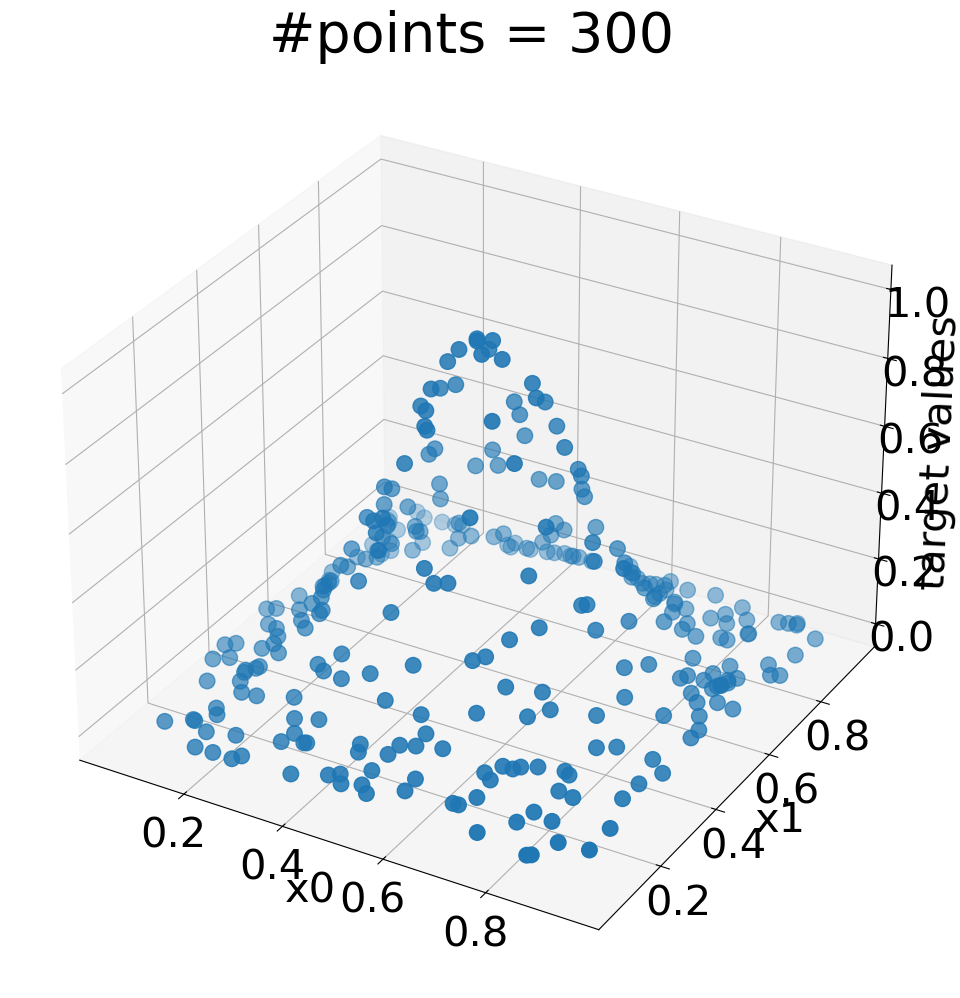

Plot of the function: 


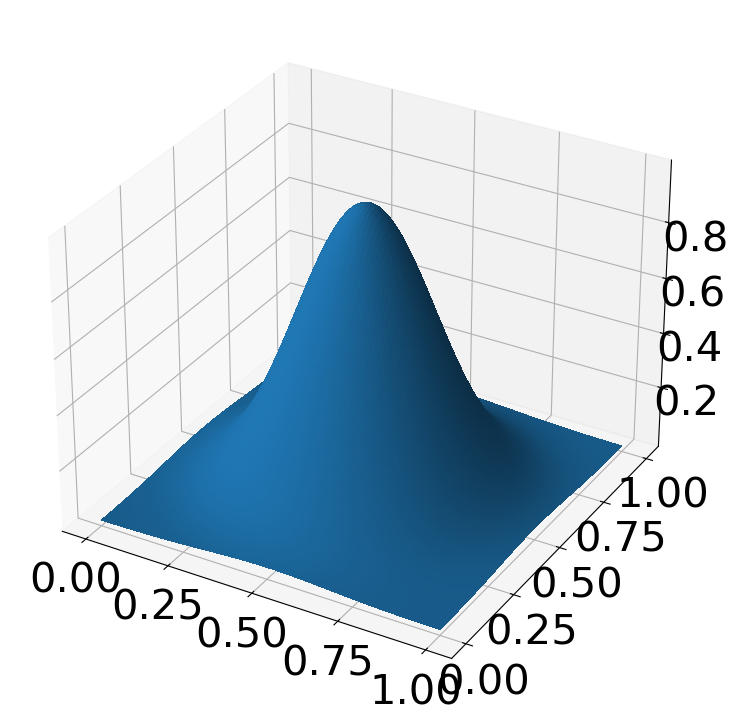

Using noisy data
Time used (s):0.025797488997341134
Number of distinct points used during the refinement (StdCombi): 95


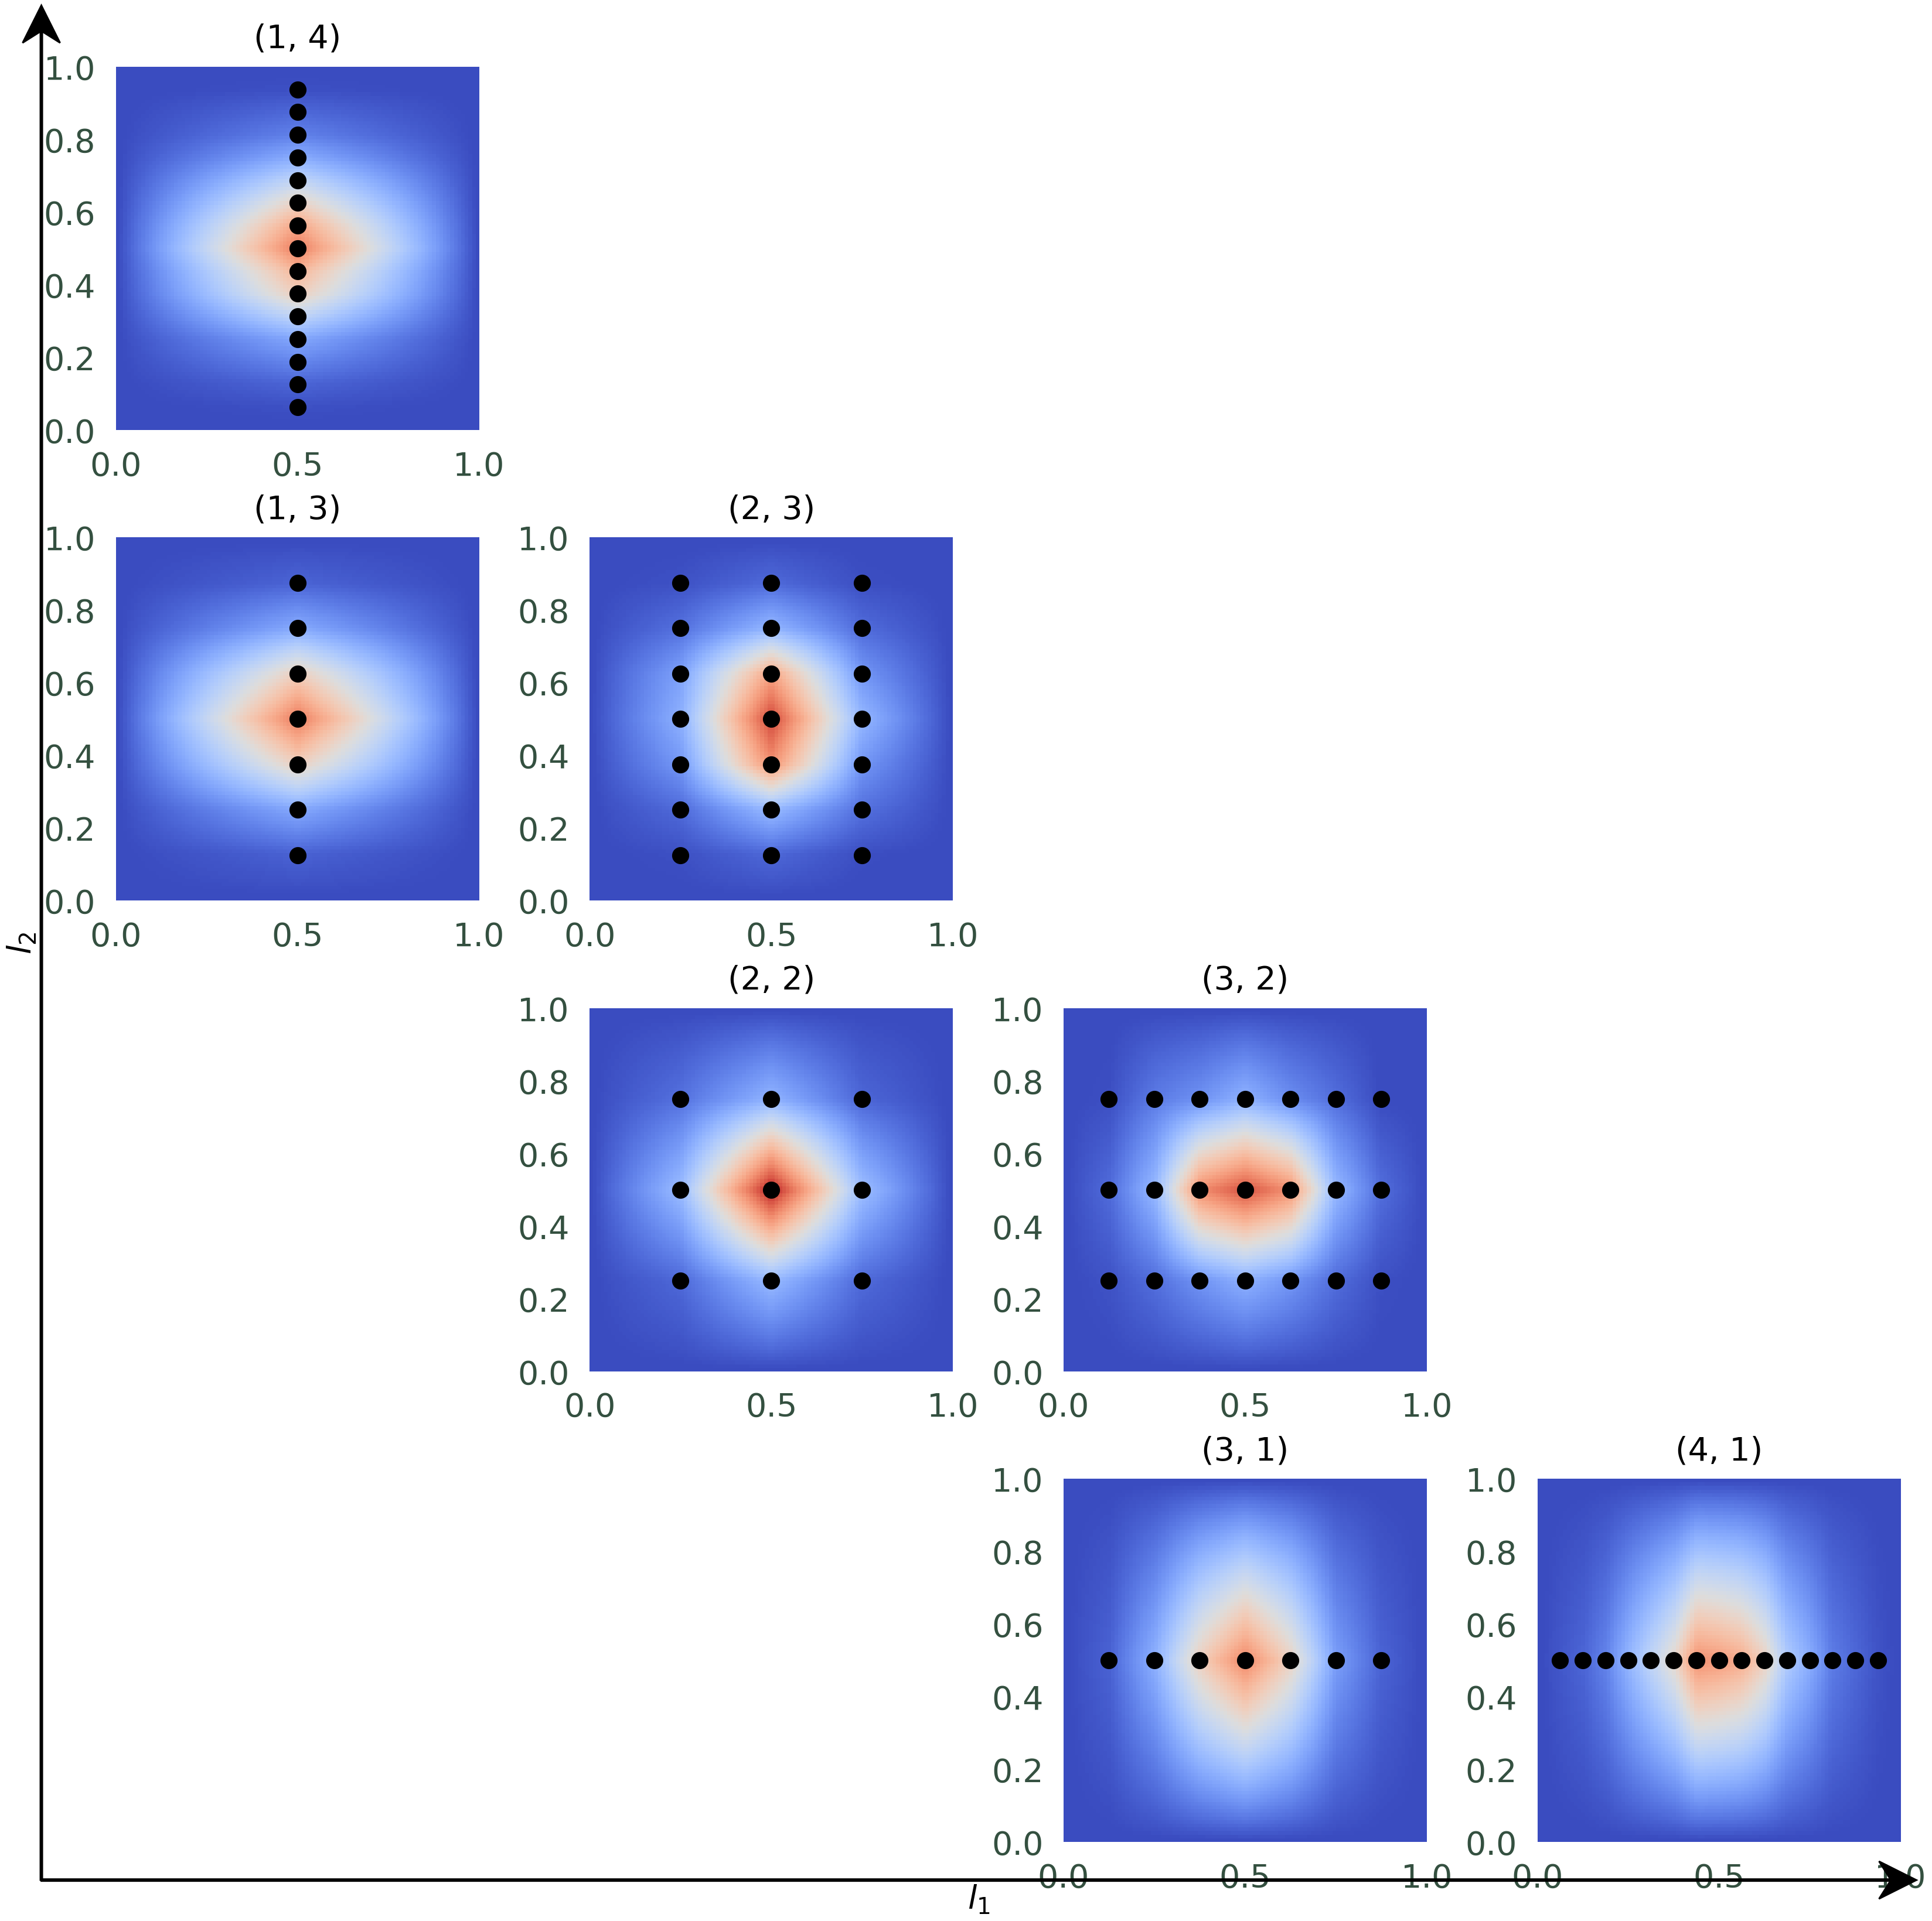

Sparse Grid:


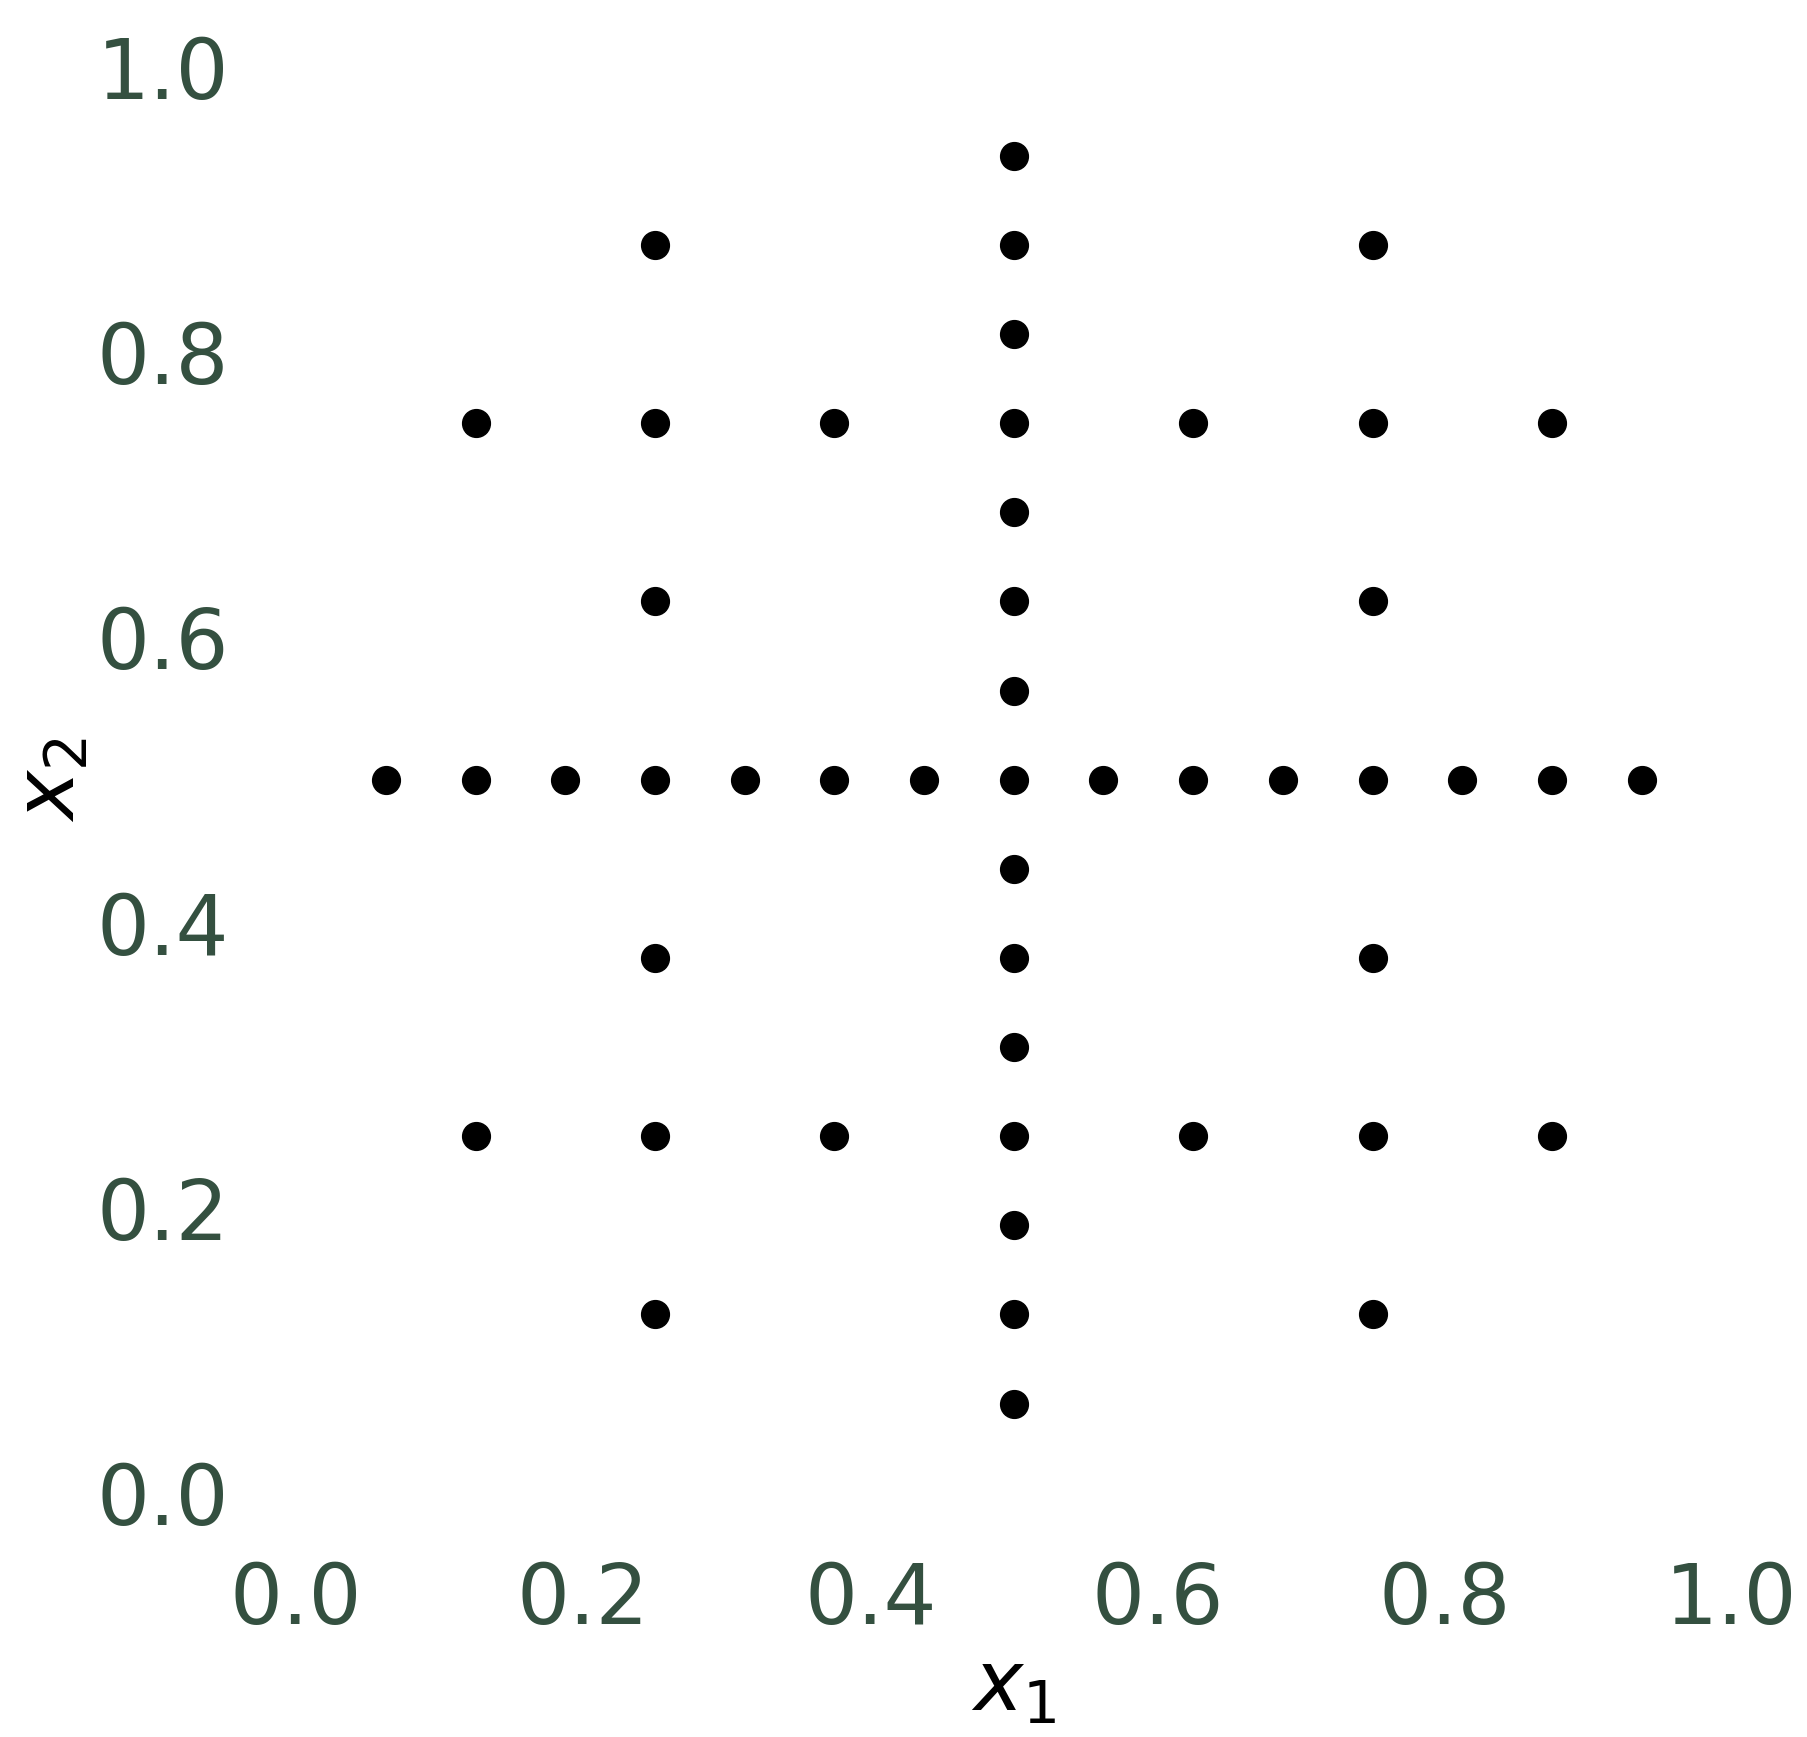

Plot of Regression:


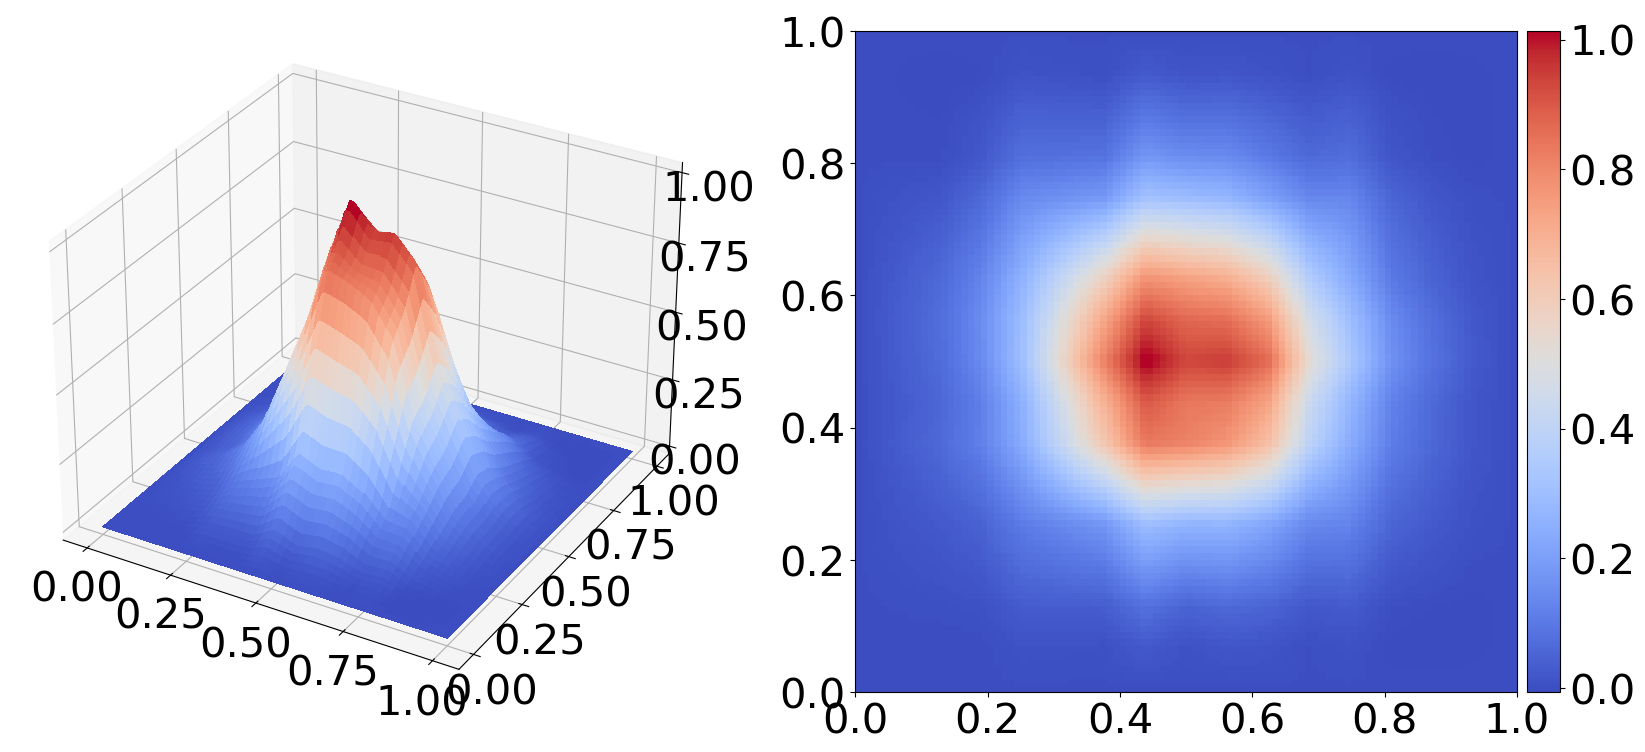

Testing error without Opticom: 
0.00039409459228734265
Time used: 
0.025797488997341134
Least squares based (without regularization) ansatz
Testing error with Opticom: 
0.00015074339657638003


In [1]:
# import sparseSpACE
%matplotlib inline
import numpy as np
from sparseSpACE.ErrorCalculator import *
from sparseSpACE.GridOperation import *
from sparseSpACE.StandardCombi import *
from sparseSpACE.DEMachineLearning import *
import math

def construct_dataset(dim, function, num_points):
    grid_points = np.random.rand(num_points,dim)
    y_vals = np.array([function(x) for x in grid_points])
    return grid_points, y_vals.flatten()

dim = 2                              
number_samples = 300                 
regularization_matrix = 'C'          # other possibility: 'I'
regularization_parameter = 10.**-6   # parameter lambda -> prevent overfitting

# set up function and draw samples
function = GenzGaussian((0.5,0.5), (15,15))
data, target = construct_dataset(dim, function, number_samples)

# initialize regression object
operation = Regression(data, target, regularization_parameter, regularization_matrix)


print("Plot of the data samples: ")
operation.plot_dataset()
print("Plot of the function: ")
function.plot((0,0),(1,1))

# train the regression object
combiObject = operation.train(percentage_of_testdata=0.2, minimum_level=1, maximum_level=4, noisy_data=True)
# print combination scheme with partial results
combiObject.print_resulting_combi_scheme(operation=operation)
# print resulting sparse grid
print("Sparse Grid:")
combiObject.print_resulting_sparsegrid(markersize=20)
# print combined result
print("Plot of Regression:")
combiObject.plot(contour=True)
# calculate current error (without Opticom)
print("Testing error without Opticom: ")
print(operation.test(combiObject))
print("Time used: ")
print(combiObject.get_time_used())
# perform Opticom (option can be changed)
operation.optimize_coefficients(combiObject, option=2)
# calculate error after Opticom
print("Testing error with Opticom: ")
print(operation.test(combiObject))

Matrix used: C
Plot of the data samples: 


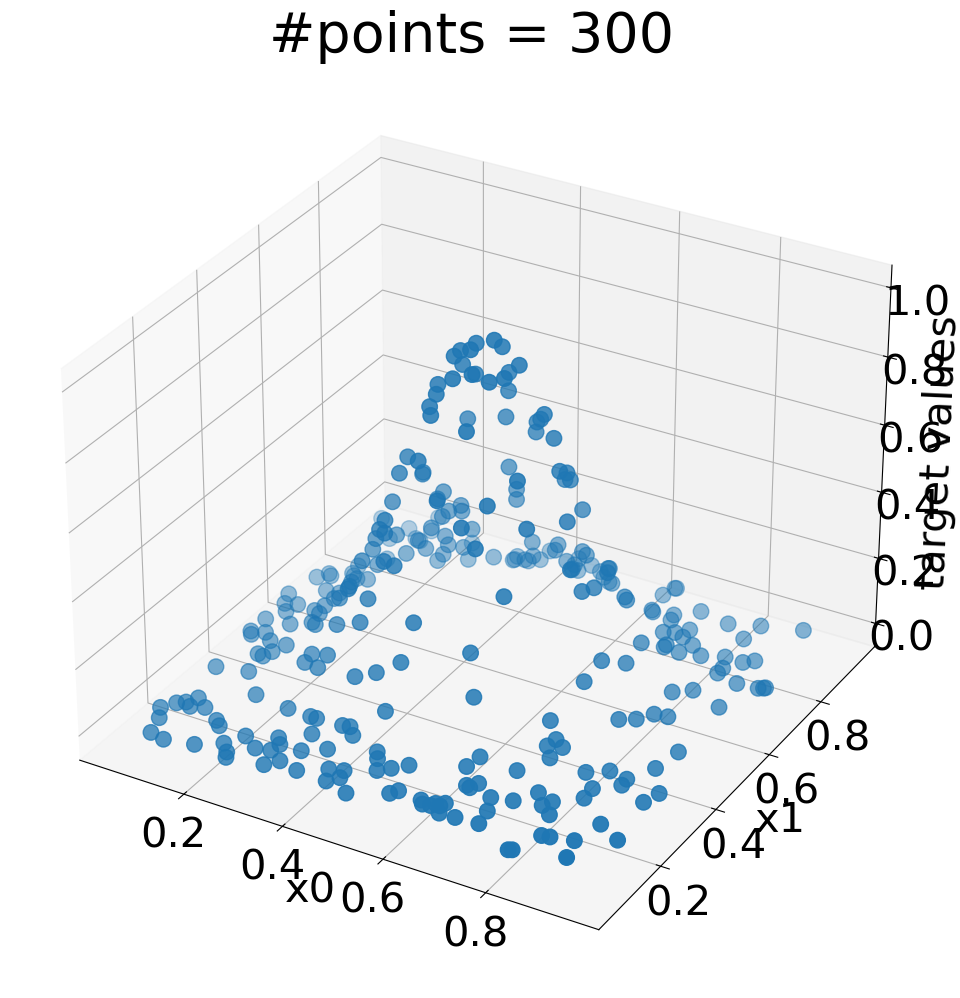

Plot of the function: 


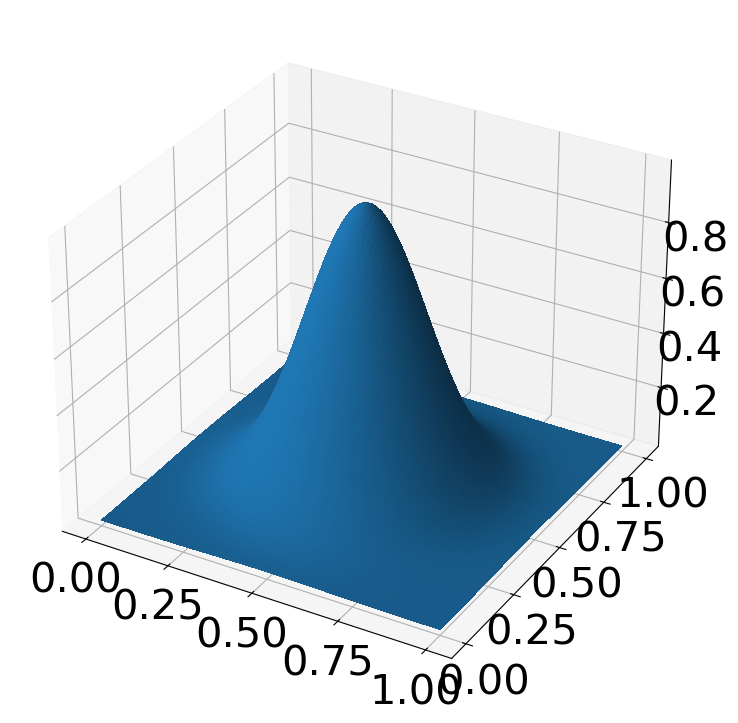

0 [1, 2] 1.0
1 [2, 1] 1.0
2 [1, 1] -1.0
Current number of function evaluations 7
Current error: 0.17147429576503592
Finished refinement
Refined 8 times
Current number of function evaluations 29
Current error: 0.011751266364524424
Number of refinements: 8
Number of distinct points used during the refinement: 29
Time used adaptive (s): 0.009610667999368161
Final error: 0.011751266364524424


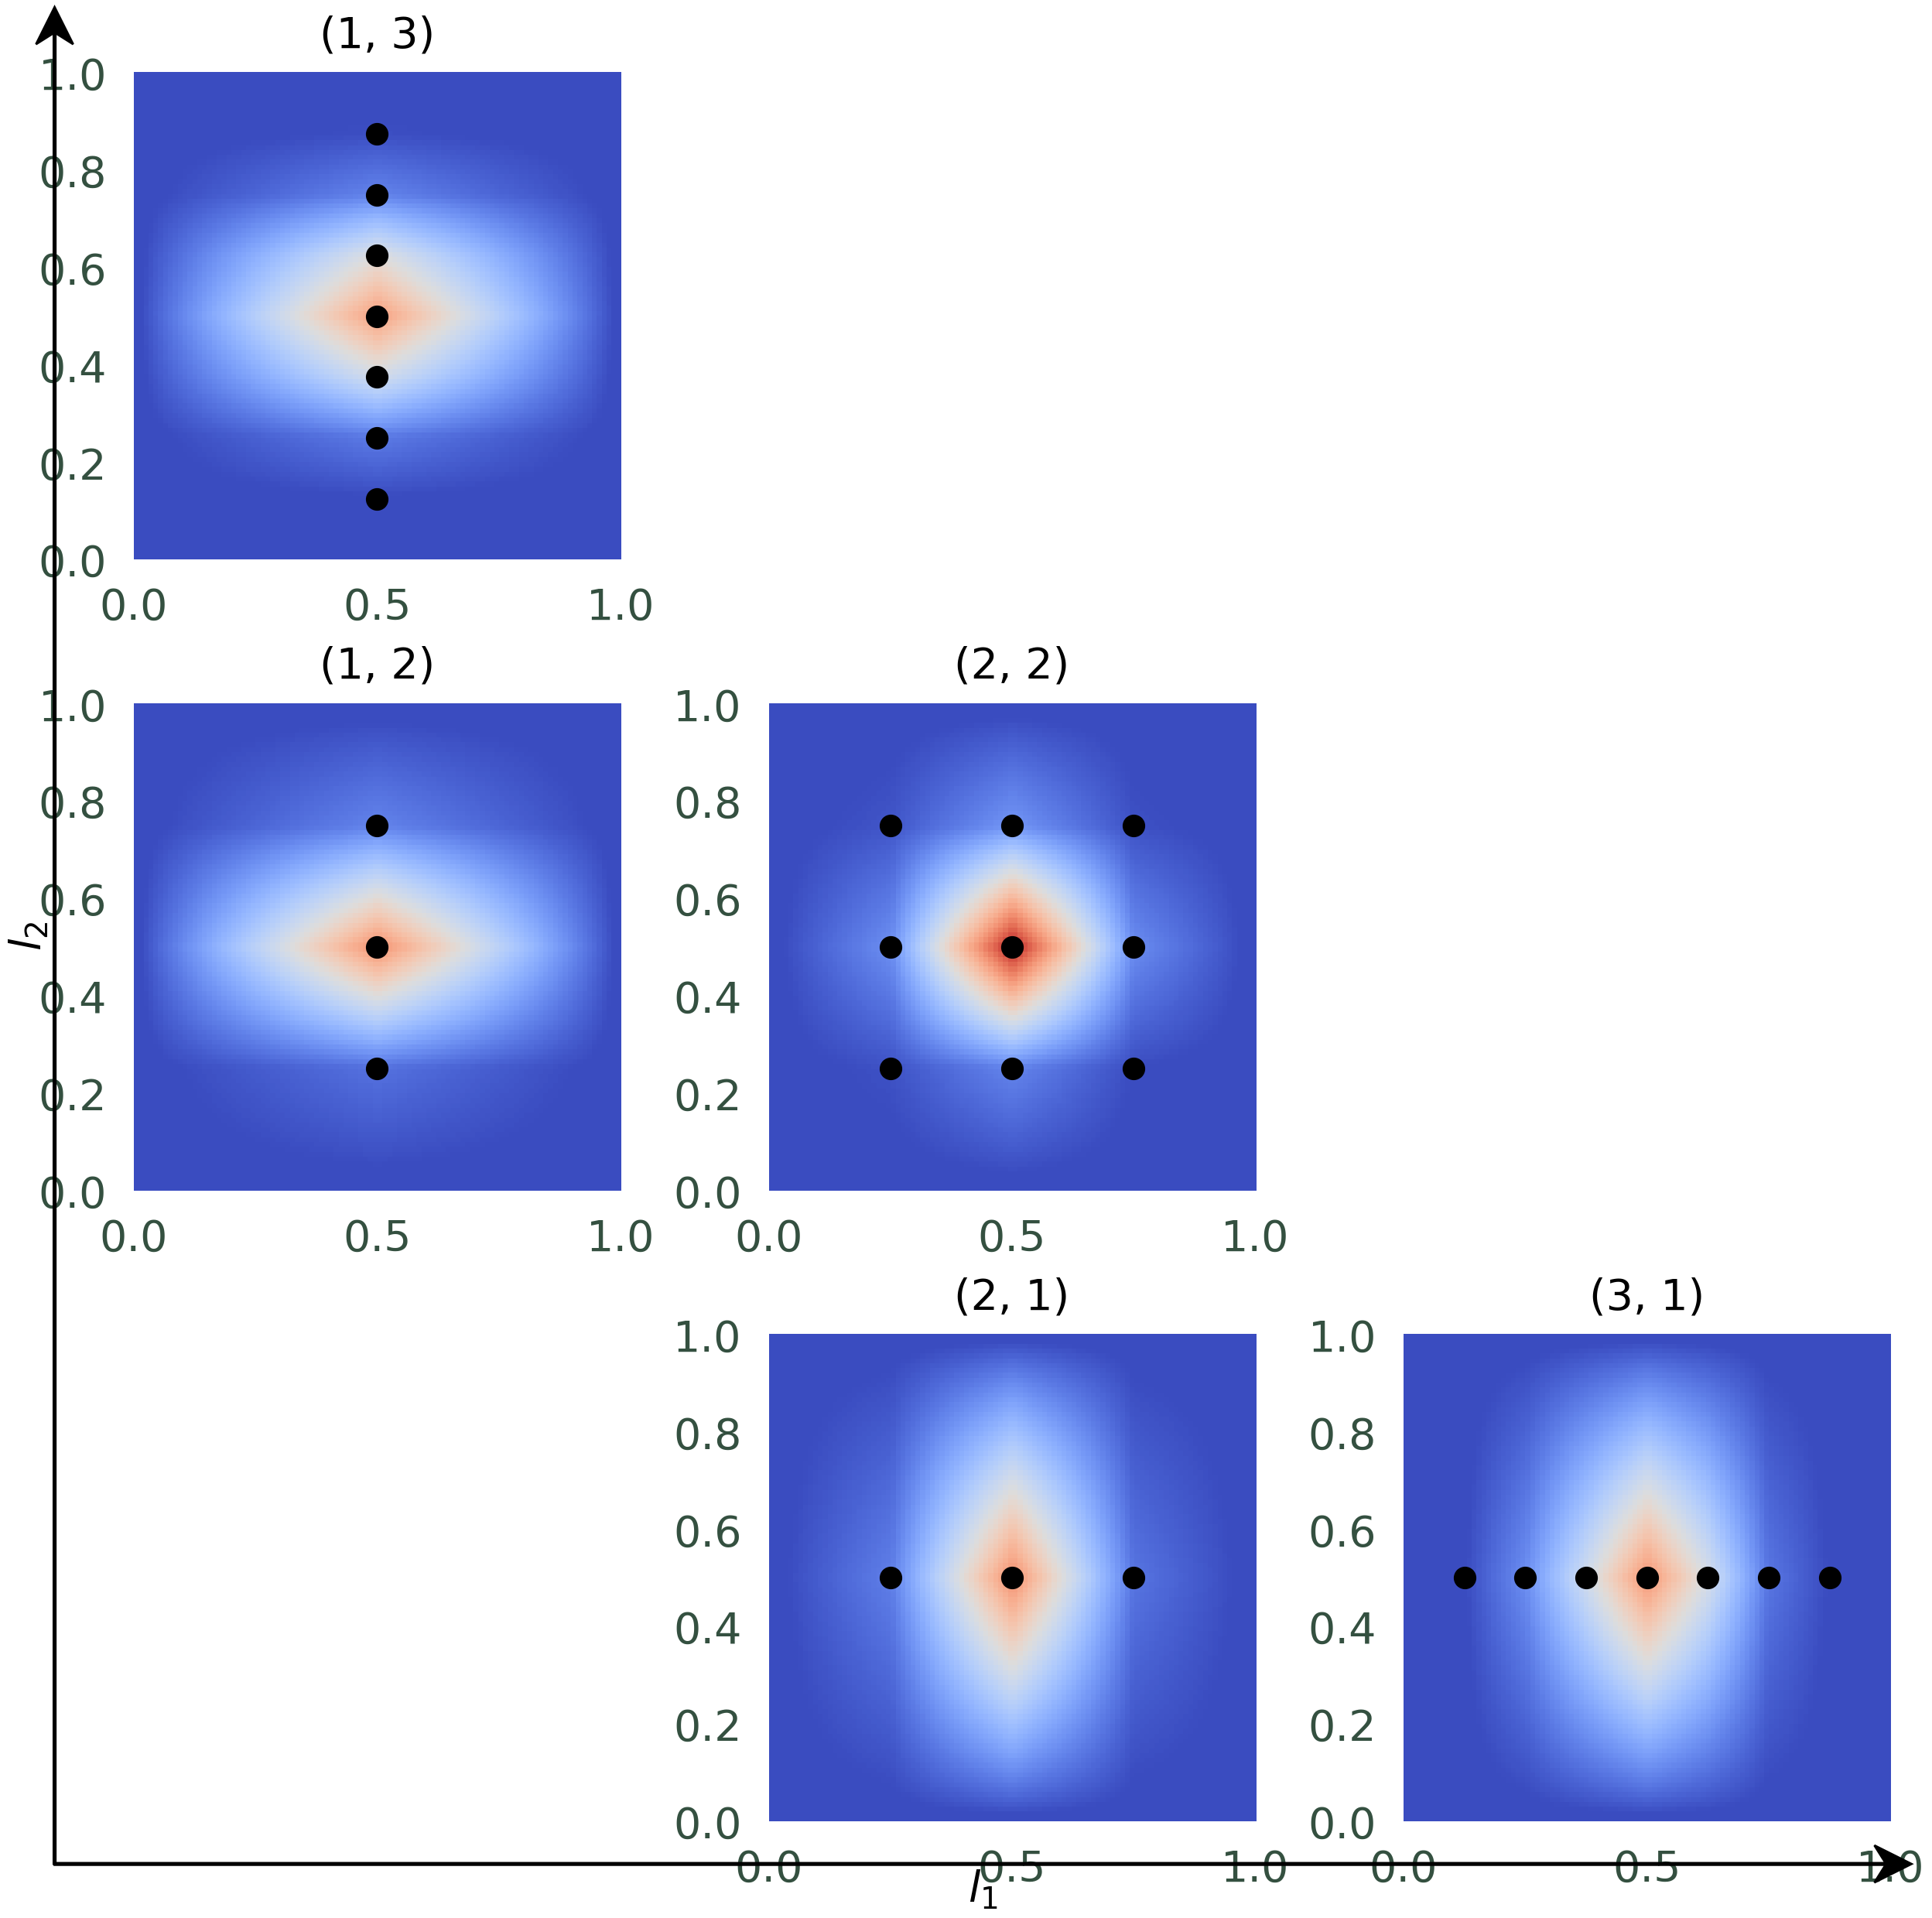

Sparse Grid:


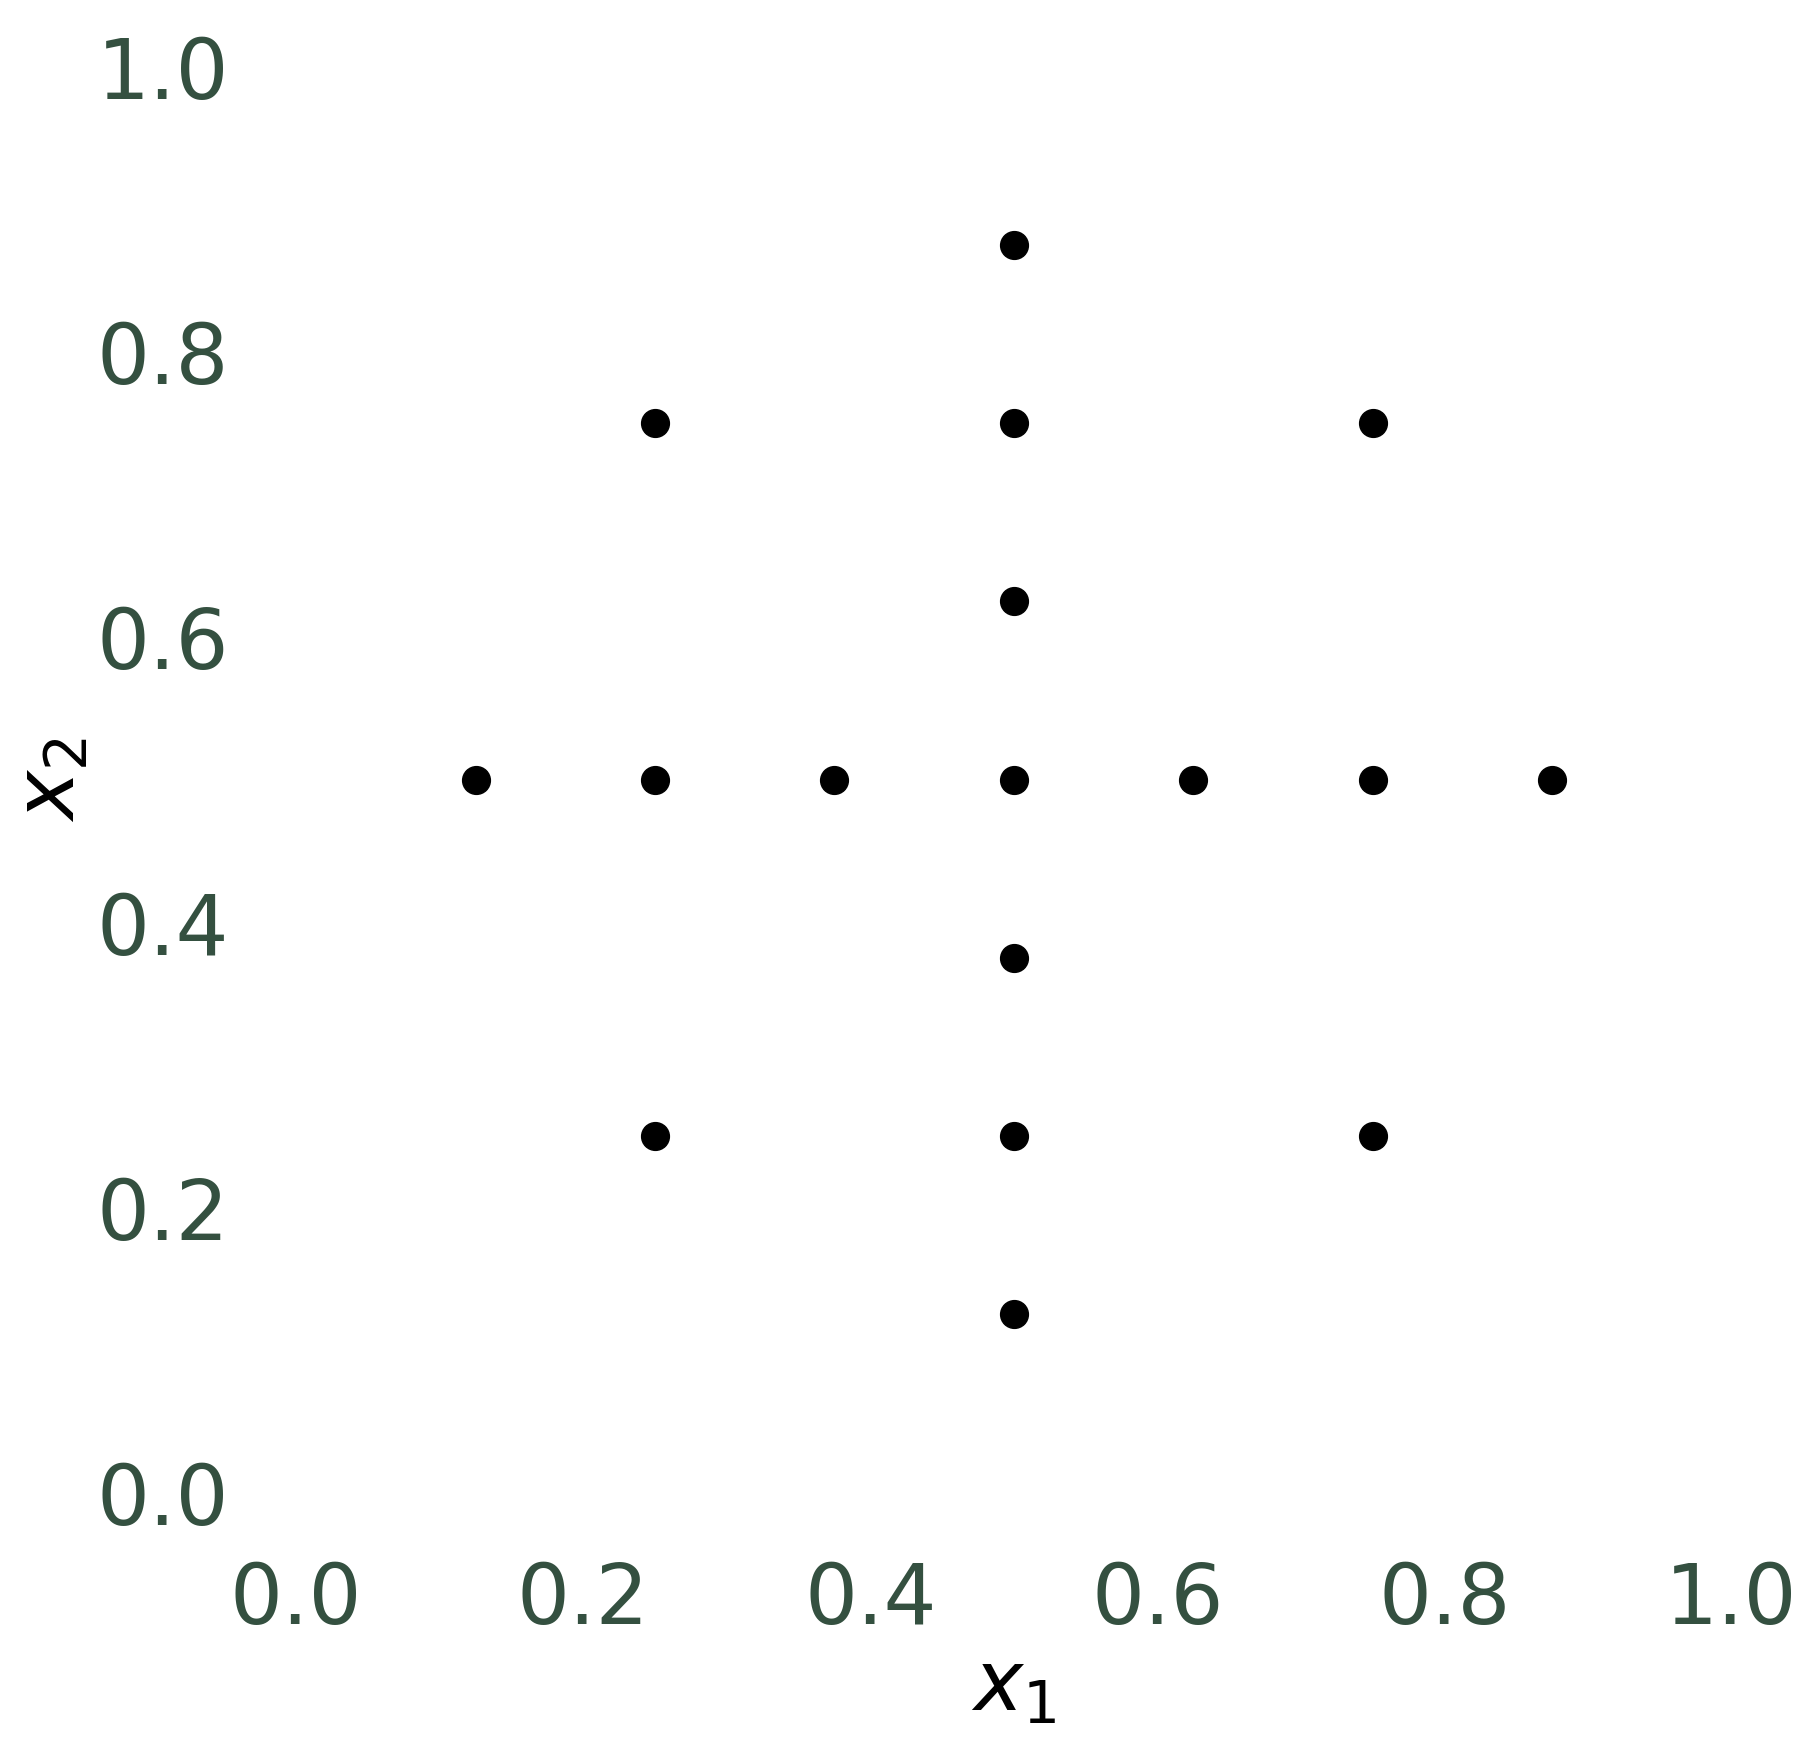

Plot of Regression:


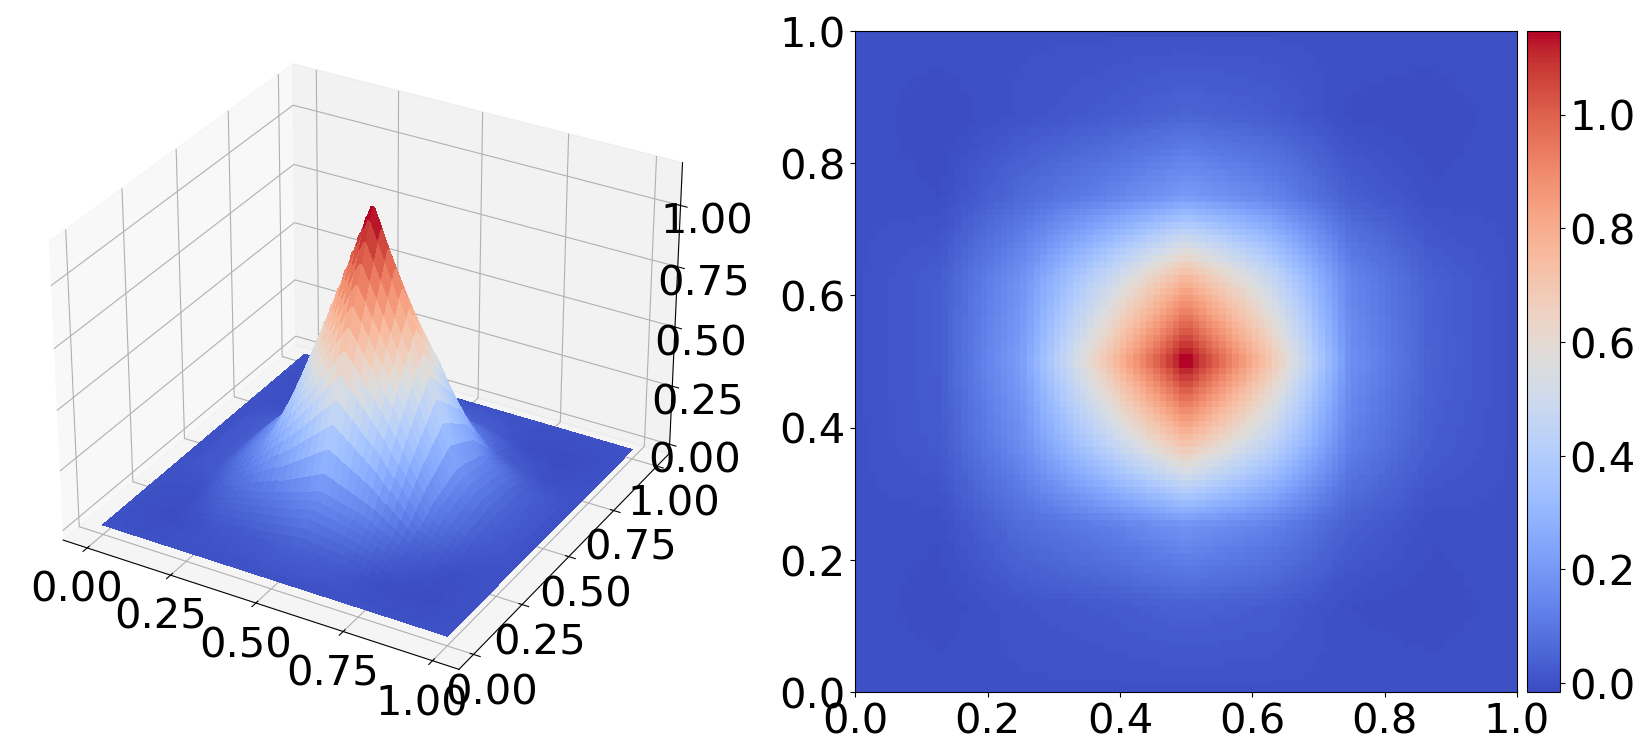

Testing error without Opticom: 
0.0004740266805132413
Own ansatz
Testing error with Opticom: 
0.00046985586778027145


In [2]:
# import sparseSpACE
%matplotlib inline
import numpy as np
from sparseSpACE.ErrorCalculator import *
from sparseSpACE.GridOperation import *
from sparseSpACE.StandardCombi import *
from sparseSpACE.DEMachineLearning import *
import math

def construct_dataset(dim, function, num_points):
    grid_points = np.random.rand(num_points,dim)
    y_vals = np.array([function(x) for x in grid_points])
    return grid_points, y_vals.flatten()


dim = 2                              
number_samples = 300                 
regularization_matrix = 'C'          # other possibility: 'I'
regularization_parameter = 10.**-6   # parameter lambda -> prevent overfitting

# set up function and draw samples
function = GenzGaussian((0.5,0.5), (20,20))
data, target = construct_dataset(dim, function, number_samples)

# initialize regression object
operation = Regression(data, target, regularization_parameter, regularization_matrix)


print("Plot of the data samples: ")
operation.plot_dataset()
print("Plot of the function: ")
function.plot((0,0),(1,1))
# train the regression object
adaptiveCombiInstanceSingleDim = operation.train_spatially_adaptive(percentage_of_testdata=0.2, margin=0.7, tolerance=10.**-5, max_evaluations=18, do_plot=False, noisy_data=False)
# print combination scheme 
adaptiveCombiInstanceSingleDim.print_resulting_combi_scheme(operation=operation)
# print resulting sparse grid
print("Sparse Grid:")
adaptiveCombiInstanceSingleDim.print_resulting_sparsegrid(markersize=20)
# print combined result
print("Plot of Regression:")
adaptiveCombiInstanceSingleDim.plot(contour=True)
# calculate error without Opticom
print("Testing error without Opticom: ")
print(operation.test_spatially_adaptive(adaptiveCombiInstanceSingleDim))
# perform Opticom (option can be changed)
operation.optimize_coefficients_spatially_adaptive(adaptiveCombiInstanceSingleDim, option=2)
# calculate error without Opticom
print("Testing error with Opticom: ")
print(operation.test_spatially_adaptive(adaptiveCombiInstanceSingleDim))